In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score, f1_score,confusion_matrix,precision_score, recall_score,roc_auc_score,precision_recall_curve,balanced_accuracy_score
import optuna

In [5]:
df=pd.read_csv('CICIDS2018/02-14-2018.csv')

In [6]:
df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [4]:
df.shape

(1048575, 80)

In [5]:
df['Label'].value_counts()

Label
Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: count, dtype: int64

In [6]:
df.isnull().sum()

Dst Port         0
Protocol         0
Timestamp        0
Flow Duration    0
Tot Fwd Pkts     0
                ..
Idle Mean        0
Idle Std         0
Idle Max         0
Idle Min         0
Label            0
Length: 80, dtype: int64

In [7]:
col=df.columns
col

Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
      

In [8]:
df=df.drop(columns='Timestamp')

In [9]:
df.head()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,112641719,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,112641466,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,112638623,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,6453966,15,10,1239,2273,744,0,82.600000,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,8804066,14,11,1143,2209,744,0,81.642857,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [10]:
zero_variance_cols = [col for col in df.columns if df[col].nunique() <= 1]
zero_variance_cols

['Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'CWE Flag Count',
 'Fwd Byts/b Avg',
 'Fwd Pkts/b Avg',
 'Fwd Blk Rate Avg',
 'Bwd Byts/b Avg',
 'Bwd Pkts/b Avg',
 'Bwd Blk Rate Avg']

In [11]:
df=df.drop(columns=zero_variance_cols)

In [12]:
zero_variance_cols = [col for col in df.columns if df[col].nunique() <= 1]
zero_variance_cols

[]

In [13]:
inf_nan_cols = df.columns[df.isin([np.inf, -np.inf]).any() | df.isna().any()]
inf_nan_cols

Index(['Flow Byts/s', 'Flow Pkts/s'], dtype='object')

In [14]:
df['Flow Byts/s'] = df['Flow Byts/s'].replace([np.inf, -np.inf], np.nan)
df['Flow Pkts/s'] = df['Flow Pkts/s'].replace([np.inf, -np.inf], np.nan)

In [15]:
df['Flow Byts/s'] = df['Flow Byts/s'].fillna(0)
df['Flow Pkts/s'] = df['Flow Pkts/s'].fillna(0)

In [16]:
inf_nan_cols = df.columns[df.isin([np.inf, -np.inf]).any() | df.isna().any()]
inf_nan_cols

Index([], dtype='object')

In [17]:
df_benign = df[df['Label'] == 'Benign']
df_attack = df[df['Label'] != 'Benign']

In [18]:
df_benign['Label'].value_counts()

Label
Benign    667626
Name: count, dtype: int64

In [19]:
df_attack['Label'].value_counts()

Label
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: count, dtype: int64

In [20]:
print(df_benign.shape,df_attack.shape)

(667626, 69) (380949, 69)


In [21]:
# 1. Split Benign into Train and Temp (for Val/Test)
X_benign_train, X_benign_temp = train_test_split(df_benign, test_size=0.3, random_state=42)

# 2. Split Temp Benign into Validation and Test
X_benign_val, X_benign_test = train_test_split(X_benign_temp, test_size=0.5, random_state=42)

# 3. Split Attack Data into Validation and Test
df_attack_val, df_attack_test = train_test_split(df_attack, test_size=0.5, random_state=42)

# 4. Construct the Sets
# TRAIN: Pure Benign
X_train = X_benign_train.drop(columns=['Label'])

# VALIDATION: Mixed (Used for Optuna & Threshold Tuning)
val_df = pd.concat([X_benign_val, df_attack_val])
X_val = val_df.drop(columns=['Label'])
y_val = val_df['Label'].apply(lambda x: 0 if x=='Benign' else 1)

# TEST: Mixed (Used ONLY for final report)
test_df = pd.concat([X_benign_test, df_attack_test])
X_test = test_df.drop(columns=['Label'])
y_test = test_df['Label'].apply(lambda x: 0 if x=='Benign' else 1)

In [22]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [26]:
def objective(trial):
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_samples': trial.suggest_float('max_samples', 0.3, 1.0),
        'max_features': trial.suggest_float('max_features', 0.3, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    # Train model (contamination is dummy since we'll use custom threshold)
    model = IsolationForest(
        **params,
        contamination='auto',  
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train_scaled)
    
    # Get scores on VALIDATION set
    raw_scores = model.decision_function(X_val_scaled)
    
    # Invert scores: HIGH positive = anomaly, LOW negative = normal
    y_scores = -1 * raw_scores
    
    # Calculate ROC-AUC on validation set
    auc = roc_auc_score(y_val, y_scores)
    
    return auc

In [27]:
print("Starting Optuna optimization (30 trials)...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2025-11-22 20:05:20,515] A new study created in memory with name: no-name-d684d2b7-a3a8-4b50-a7ee-272be40bd77b


Starting Optuna optimization (30 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-22 20:05:51,824] Trial 0 finished with value: 0.9627266981669226 and parameters: {'n_estimators': 235, 'max_samples': 0.9276774550414304, 'max_features': 0.566348194141933, 'bootstrap': True}. Best is trial 0 with value: 0.9627266981669226.
[I 2025-11-22 20:06:58,312] Trial 1 finished with value: 0.9584000129201478 and parameters: {'n_estimators': 350, 'max_samples': 0.8297644207103951, 'max_features': 0.9536681288125175, 'bootstrap': False}. Best is trial 0 with value: 0.9627266981669226.
[I 2025-11-22 20:07:52,962] Trial 2 finished with value: 0.9638489431859973 and parameters: {'n_estimators': 366, 'max_samples': 0.47958252408373514, 'max_features': 0.9924675938834677, 'bootstrap': True}. Best is trial 2 with value: 0.9638489431859973.
[I 2025-11-22 20:08:13,267] Trial 3 finished with value: 0.9600330212797487 and parameters: {'n_estimators': 143, 'max_samples': 0.722436596489457, 'max_features': 0.7473512060522272, 'bootstrap': True}. Best is trial 2 with value: 0.963848

In [28]:
print(f"Best ROC-AUC: {study.best_trial.value:.4f}")
print(f"Best Parameters: {study.best_trial.params}")
best_params = study.best_trial.params

Best ROC-AUC: 0.9817
Best Parameters: {'n_estimators': 62, 'max_samples': 0.8755375798951086, 'max_features': 0.7960595738607978, 'bootstrap': True}


In [29]:
final_model = IsolationForest(
    **best_params,
    contamination='auto',  # Dummy (using custom threshold)
    random_state=42,
    n_jobs=-1
)

print("Training on full training set...")
final_model.fit(X_train_scaled)

Training on full training set...


IsolationForest(bootstrap=True, max_features=0.7960595738607978,
                max_samples=0.8755375798951086, n_estimators=62, n_jobs=-1,
                random_state=42)

In [32]:
print("\nFinding optimal threshold using VALIDATION set...")

# Get validation scores
val_raw_scores = final_model.decision_function(X_val_scaled)
val_y_scores = -1 * val_raw_scores  # Invert: HIGH = anomaly

# Use Precision-Recall curve to find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_val, val_y_scores)

# Calculate F1 for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

# Find best threshold
best_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[best_idx]
best_val_f1 = f1_scores[best_idx]


Finding optimal threshold using VALIDATION set...


In [33]:
print(f"   Validation F1: {best_val_f1:.4f}")
print(f"   Validation Precision: {precision[best_idx]:.4f}")
print(f"   Validation Recall: {recall[best_idx]:.4f}")

   Validation F1: 0.9751
   Validation Precision: 0.9597
   Validation Recall: 0.9909


In [37]:
# Get test scores
test_raw_scores = final_model.decision_function(X_test_scaled)
test_y_scores = -1 * test_raw_scores

# Apply optimal threshold
final_predictions = (test_y_scores >= optimal_threshold).astype(int)

# Calculate comprehensive metrics
test_f1 = f1_score(y_test, final_predictions)
test_auc = roc_auc_score(y_test, test_y_scores)
test_balanced_acc = balanced_accuracy_score(y_test, final_predictions)

In [54]:
y_test

857853    0
793862    0
489741    0
840408    0
786502    0
         ..
162552    1
307731    1
335437    1
22052     1
313341    1
Name: Label, Length: 290619, dtype: int64

In [55]:
final_predictions

array([0, 0, 0, ..., 1, 1, 1])

In [58]:
test_y_scores

array([-0.16239098, -0.17401074, -0.15298227, ..., -0.08730041,
       -0.03284269, -0.08716483])

In [51]:
print(f"The Optimal Anomaly Threshold is: {optimal_threshold:.6f}")

The Optimal Anomaly Threshold is: -0.122294


In [38]:
print(f"   F1 Score: {test_f1:.4f}")
print(f"   ROC-AUC: {test_auc:.4f}")
print(f"   Balanced Accuracy: {test_balanced_acc:.4f}")

   F1 Score: 0.9748
   ROC-AUC: 0.9820
   Balanced Accuracy: 0.9558


In [39]:
print(classification_report(
    y_test, 
    final_predictions,
    target_names=['Benign (0)', 'Attack (1)'],
    digits=4
))

              precision    recall  f1-score   support

  Benign (0)     0.9802    0.9213    0.9499    100144
  Attack (1)     0.9599    0.9902    0.9748    190475

    accuracy                         0.9665    290619
   macro avg     0.9700    0.9558    0.9623    290619
weighted avg     0.9669    0.9665    0.9662    290619



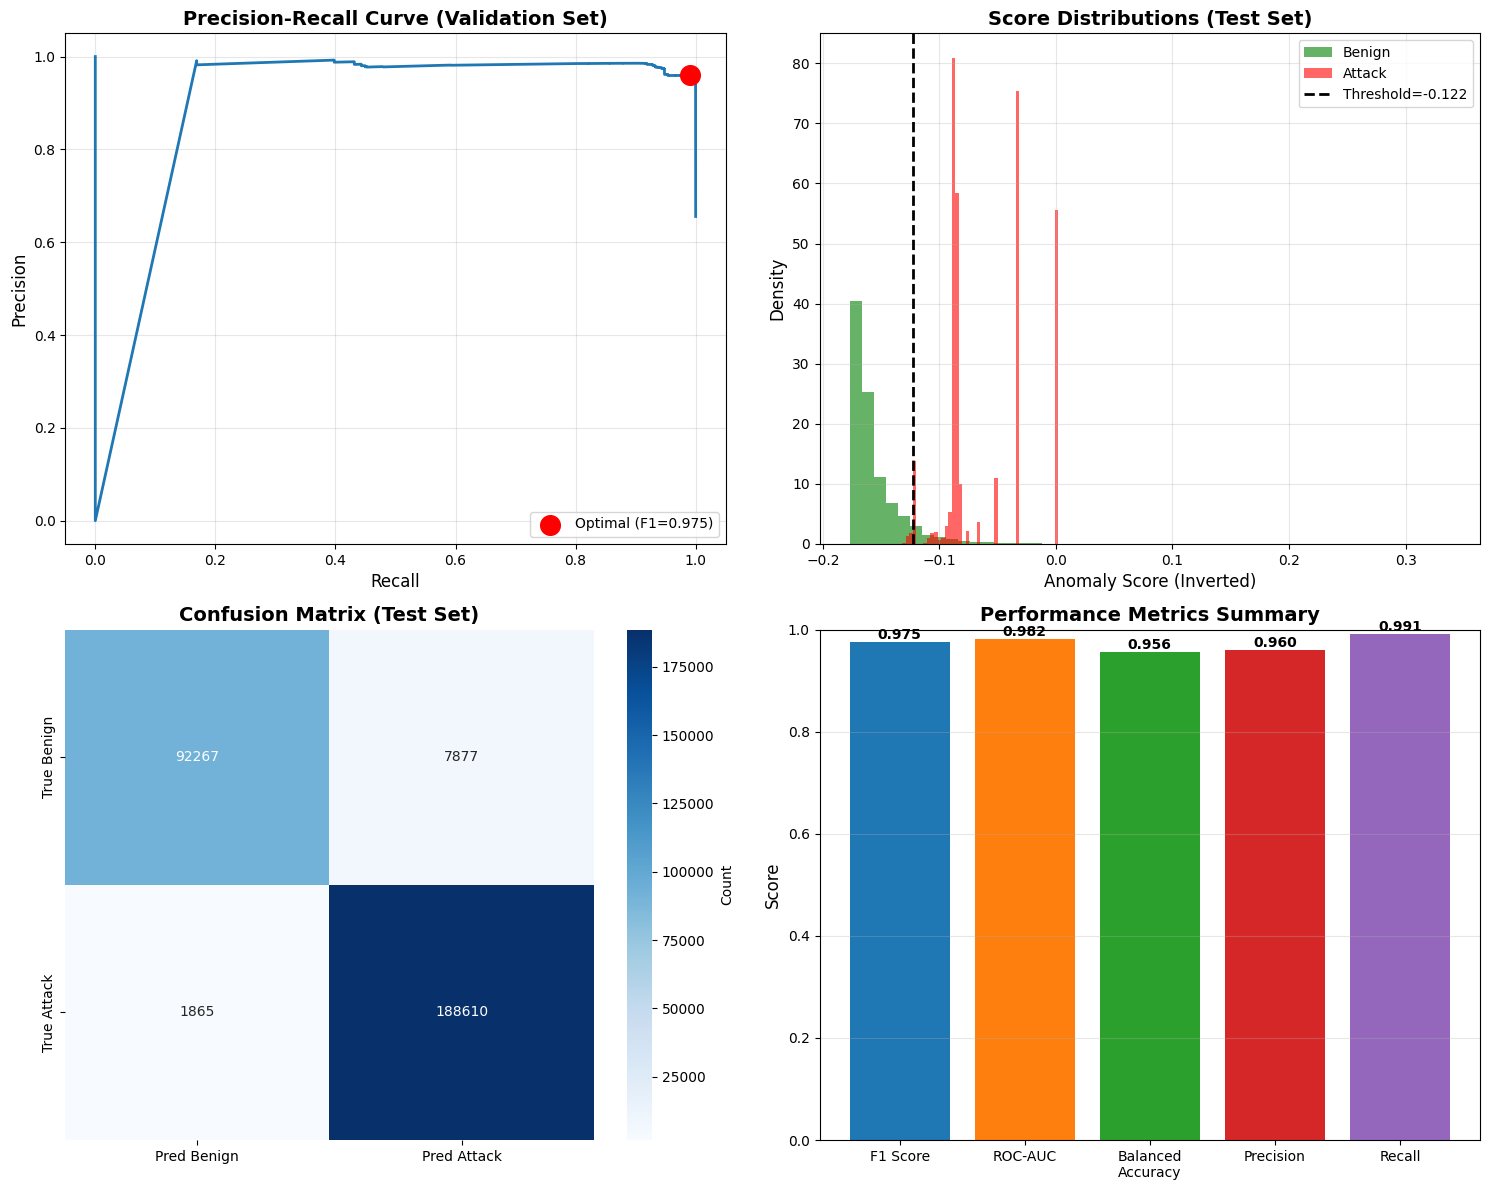

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Precision-Recall Curve
ax1 = axes[0, 0]
ax1.plot(recall, precision, linewidth=2)
ax1.scatter(
    recall[best_idx], 
    precision[best_idx], 
    color='red', 
    s=200, 
    zorder=5,
    label=f'Optimal (F1={best_val_f1:.3f})'
)
ax1.set_xlabel('Recall', fontsize=12)
ax1.set_ylabel('Precision', fontsize=12)
ax1.set_title('Precision-Recall Curve (Validation Set)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Score Distribution
ax2 = axes[0, 1]
ax2.hist(
    test_y_scores[y_test==0], 
    bins=50, 
    alpha=0.6, 
    label='Benign', 
    color='green',
    density=True
)
ax2.hist(
    test_y_scores[y_test==1], 
    bins=50, 
    alpha=0.6, 
    label='Attack', 
    color='red',
    density=True
)
ax2.axvline(
    optimal_threshold, 
    color='black', 
    linestyle='--', 
    linewidth=2,
    label=f'Threshold={optimal_threshold:.3f}'
)
ax2.set_xlabel('Anomaly Score (Inverted)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Score Distributions (Test Set)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Confusion Matrix
ax3 = axes[1, 0]
cm = confusion_matrix(y_test, final_predictions)
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    ax=ax3,
    xticklabels=['Pred Benign', 'Pred Attack'],
    yticklabels=['True Benign', 'True Attack'],
    cbar_kws={'label': 'Count'}
)
ax3.set_title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')

# Plot 4: Metrics Comparison
ax4 = axes[1, 1]
metrics = {
    'F1 Score': test_f1,
    'ROC-AUC': test_auc,
    'Balanced\nAccuracy': test_balanced_acc,
    'Precision': precision[best_idx],
    'Recall': recall[best_idx]
}
bars = ax4.bar(metrics.keys(), metrics.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax4.set_ylim(0, 1)
ax4.set_ylabel('Score', fontsize=12)
ax4.set_title('Performance Metrics Summary', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax4.text(
        bar.get_x() + bar.get_width()/2., 
        height,
        f'{height:.3f}',
        ha='center', 
        va='bottom',
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig('isolation_forest_results.png', dpi=300, bbox_inches='tight')
plt.show()